# Notebook: Correlation between Generation Length and Example Length

## Packages

In [1]:
import spacy
import random
import json
import nltk
from nltk.tokenize import word_tokenize
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from pathlib import Path
import matplotlib as mpl

## Settings

In [19]:
FS_CONDITIONS = ["fixed", "random"]
LLMS = ["Llama70B", "GPT-3"]
RANDOM_STATE = 43
N_FOLDS = 6

In [20]:
LLMS_ENCODED = {"GPT-3": "GPT-3.5-turbo",
                "Llama70B": "Llama-2-70B"}
ENCODE_CONDITION = {"fixed": "LRS$_{{25}}$",
                    "random": "LRS$_{{500}}$"}

In [3]:
nlp = spacy.load("de_core_news_lg")
nltk.download('punkt')
random.seed(RANDOM_STATE)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nils_hellwig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Code

In [4]:
def count_tokens(sentence):
    tokens = word_tokenize(sentence, language='german')
    return len(tokens)

In [5]:
dataset_raw = {"synth": {}}

# Load Synth
for llm in LLMS:
    dataset_raw["synth"][llm] = {}
    for prompting in FS_CONDITIONS:
        dataset_raw["synth"][llm][prompting] = []
        for split in range(N_FOLDS):
            with open(f"../07 train models/synth/{llm}/{prompting}/split_{split}.json", 'r', encoding='utf-8') as json_file:
                split_data = json.load(json_file)
            dataset_raw["synth"][llm][prompting].append(split_data)

In [6]:
def calculate_avg_len_fs_examples(llm_examples):
    return np.mean([count_tokens(example["text"]) for example in llm_examples])

In [7]:
llm_prediction_size_vs_fs_length = {"synth": {}}

In [8]:
for llm in LLMS:
    llm_prediction_size_vs_fs_length["synth"][llm] = {}
    for prompting in FS_CONDITIONS:
        llm_prediction_size_vs_fs_length["synth"][llm][prompting] = {
            "output_length": [], "fs_length": []}
        for k in range(N_FOLDS):
            examples = [example for example in dataset_raw["synth"]
                        [llm][prompting][k]]

            # 1. Calculate Output Length
            llm_prediction_size_vs_fs_length["synth"][llm][prompting]["output_length"] += [count_tokens(example["text"])
                              for example in examples]

            # 2. Calculate AVG Length of Examples in Prompt
            llm_prediction_size_vs_fs_length["synth"][llm][prompting]["fs_length"] += [calculate_avg_len_fs_examples(
                example["llm_examples"]) for example in examples]

Llama70B & fixed Correlation Coefficient (r): 0.09 & Degrees of Freedom: 11848 & p-value: p<.001 & 95% Confidence Interval: (0.09, 0.09)
Llama70B & random Correlation Coefficient (r): 0.11 & Degrees of Freedom: 8998 & p-value: p<.001 & 95% Confidence Interval: (0.11, 0.11)
GPT-3 & fixed Correlation Coefficient (r): 0.02 & Degrees of Freedom: 11848 & p-value: p=0.014 & 95% Confidence Interval: (0.02, 0.02)
GPT-3 & random Correlation Coefficient (r): 0.07 & Degrees of Freedom: 8998 & p-value: p<.001 & 95% Confidence Interval: (0.07, 0.07)


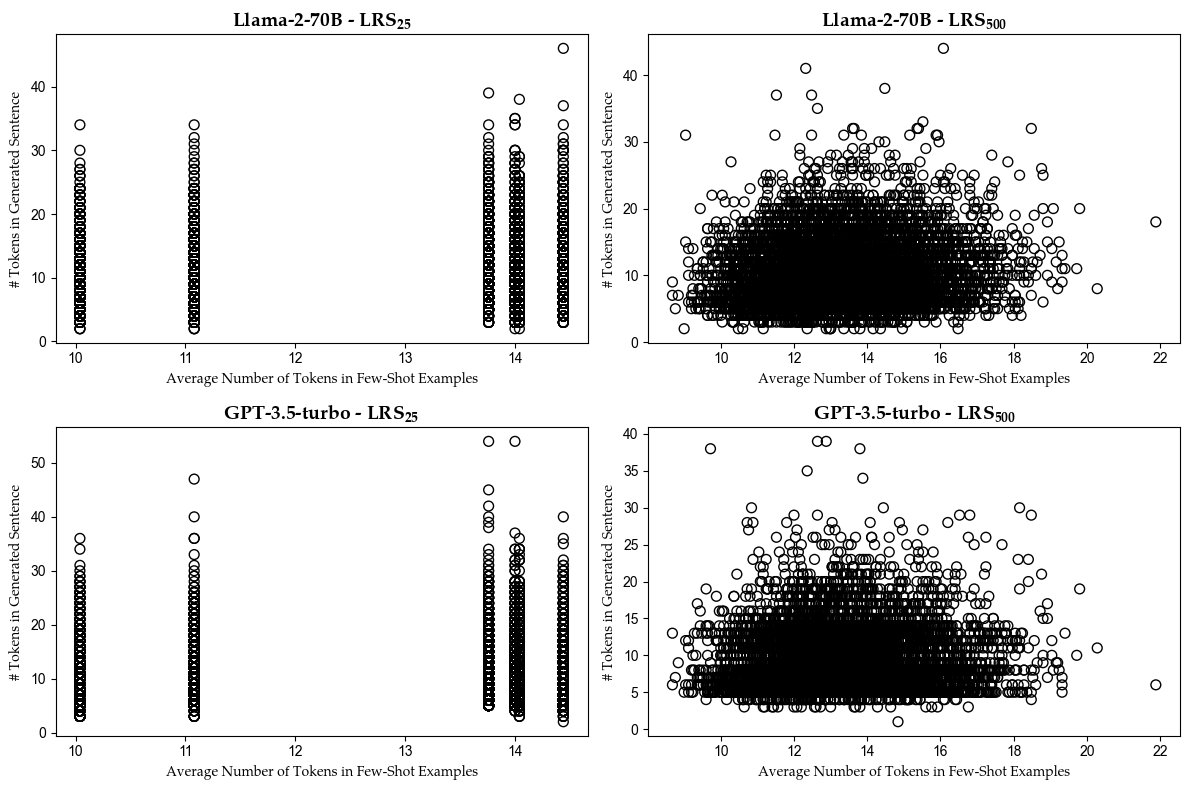

In [22]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
font_path_regular = Path('texgyrepagella-regular.otf')
custom_font_regular = FontProperties(fname=font_path_regular.as_posix())

font_path_bold = Path('texgyrepagella-bold.otf')
custom_font_bold = FontProperties(fname=font_path_bold.as_posix())

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']

fig, axs = plt.subplots(len(LLMS), len(FS_CONDITIONS), figsize=(12, 8))

for i, llm in enumerate(LLMS):
    for j, prompting in enumerate(FS_CONDITIONS):
        correlation_coefficient, p_value = pearsonr(
            llm_prediction_size_vs_fs_length["synth"][llm][prompting]["fs_length"], llm_prediction_size_vs_fs_length["synth"][llm][prompting]["output_length"])

        dof = len(llm_prediction_size_vs_fs_length["synth"][llm][prompting]["fs_length"]) - 2  # Degrees of freedom
        critical_value = np.abs(correlation_coefficient / np.sqrt(1 - correlation_coefficient**2))
        confidence_interval = (correlation_coefficient - critical_value / np.sqrt(dof), correlation_coefficient + critical_value / np.sqrt(dof))

        axs[i, j].scatter(llm_prediction_size_vs_fs_length["synth"][llm][prompting]["fs_length"],
                          llm_prediction_size_vs_fs_length["synth"][llm][prompting]["output_length"], edgecolors='black', facecolors='none', s=50)
        axs[i, j].set_xlabel('Average Number of Tokens in Few-Shot Examples', fontproperties=custom_font_regular)
        axs[i, j].set_ylabel('# Tokens in Generated Sentence', fontproperties=custom_font_regular)
        axs[i, j].set_title(f'{LLMS_ENCODED[llm]} - ' + ENCODE_CONDITION[prompting], fontproperties=custom_font_bold, fontsize=14)  # Use LaTeX syntax for subscript

        p_value_str = f'p={p_value:.3f}' if p_value >= 0.001 else 'p<.001'
        print(llm, "&", prompting, f'Correlation Coefficient (r): {correlation_coefficient:.2f}', "&", f'Degrees of Freedom: {dof}', "&", f'p-value: {p_value_str}', "&", f'95% Confidence Interval: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})')

plt.tight_layout()
plt.show()

